This notebook is meant to be run on Google Colabs. It loads preprocessed images of a couple of similar looking dog breeds and attempts to create a GAN. Due to the limitation of training time on Google Colabs the model is trained for 100 epochs and then saved. The model is then automatically loaded from google drive and trained for another 100 epochs whenever the notebook is run. If it is the first run, set "first_run"-parameter to True

The dataset and model are assumed to be saved on the users drive with corresponding directory names.

In [ ]:
#Imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import image_dataset_from_directory

In [ ]:
#Hyperparameters
image_sizes = (256,256,1)
latent_dim = 200
data_dir = "./images_similar"
batch_size = 32
EPOCHS = 100
first_run = False

In [ ]:
#checking that GPU-acceleration is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [ ]:
#Mounting drive and unzipping the images

if not os.path.exists('images_similar'):
  from google.colab import drive
  drive.mount('/content/drive')
  !unzip drive/MyDrive/images_similar.zip

Mounted at /content/drive
Archive:  drive/MyDrive/images_similar.zip
   creating: images_similar/
   creating: images_similar/n02109961-Eskimo_dog/
 extracting: images_similar/n02109961-Eskimo_dog/n02109961_16718.jpg  
 extracting: images_similar/n02109961-Eskimo_dog/n02109961_4369.jpg  
 extracting: images_similar/n02109961-Eskimo_dog/n02109961_16095.jpg  
 extracting: images_similar/n02109961-Eskimo_dog/n02109961_4157.jpg  
 extracting: images_similar/n02109961-Eskimo_dog/n02109961_2532.jpg  
 extracting: images_similar/n02109961-Eskimo_dog/n02109961_4619.jpg  
 extracting: images_similar/n02109961-Eskimo_dog/n02109961_16491.jpg  
 extracting: images_similar/n02109961-Eskimo_dog/n02109961_3956.jpg  
 extracting: images_similar/n02109961-Eskimo_dog/n02109961_8977.jpg  
 extracting: images_similar/n02109961-Eskimo_dog/n02109961_19358.jpg  
 extracting: images_similar/n02109961-Eskimo_dog/n02109961_2727.jpg  
 extracting: images_similar/n02109961-Eskimo_dog/n02109961_4801.jpg  
 extract

In [ ]:
#Using dataset from directory

train_ds = image_dataset_from_directory(
  data_dir,
  color_mode='grayscale',
  image_size=image_sizes[:2],
  batch_size=batch_size,
  labels = None)

Found 520 files belonging to 1 classes.


(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)


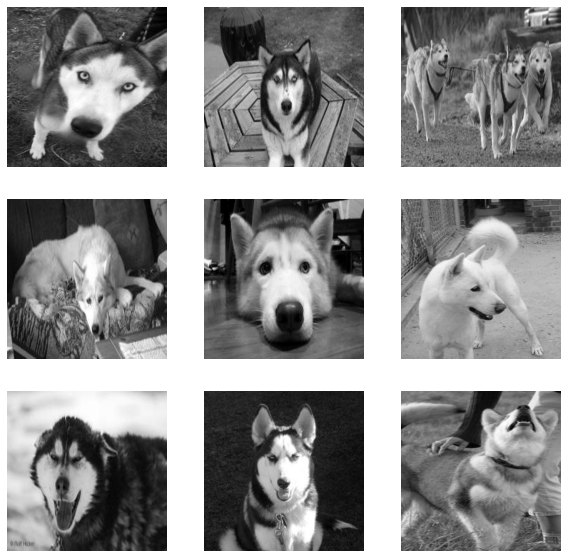

In [ ]:
#Visualizing a couple
plt.figure(figsize=(10,10))
for images in train_ds.take(1):
    for i in range(9):
        print(images[i].shape)
        ax = plt.subplot(3,3,i+1)
        plt.imshow(np.squeeze(images[i].numpy().astype("uint8")), cmap = "gray")
        plt.axis("off")

In [ ]:
#Creating the discriminator network

discriminator = Sequential()
discriminator.add(layers.Conv2D(64, 3, strides = 2, padding = 'same', input_shape = image_sizes))
discriminator.add(layers.LeakyReLU(alpha=0.2))
discriminator.add(layers.Conv2D(128,3,strides=2,padding='same'))
discriminator.add(layers.LeakyReLU(alpha=0.2))
discriminator.add(layers.Conv2D(256,3,strides=2,padding='same'))
discriminator.add(layers.LeakyReLU(alpha=0.2))
discriminator.add(layers.Conv2D(128,3,strides=2,padding='same'))
discriminator.add(layers.LeakyReLU(alpha=0.2))
discriminator.add(layers.GlobalMaxPooling2D())
discriminator.add(layers.Dense(1))

discriminator.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      640       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128, 128, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64, 64, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 256)       295168    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 32, 32, 256)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 128)       2

In [ ]:
#Creating the generator network

generator = Sequential()
generator.add(layers.Dense(8*8*128, use_bias=False, input_shape = (latent_dim,)))
generator.add(layers.LeakyReLU(0.2))
generator.add(layers.Reshape((8, 8, 128)))
generator.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
generator.add(layers.LeakyReLU(0.2))
generator.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
generator.add(layers.LeakyReLU(0.2))
generator.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
generator.add(layers.LeakyReLU(0.2))
generator.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
generator.add(layers.LeakyReLU(0.2))
generator.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
generator.add(layers.LeakyReLU(0.2))
generator.add(layers.Conv2D(1, (7, 7), padding='same', activation='sigmoid'))

generator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 8192)              1638400   
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 8192)              0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 128)      262272    
 ranspose)                                            

In [ ]:
#Putting it together into the GAN class
class GAN(Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN,self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.gen_loss_tracker = tf.keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = tf.keras.metrics.Mean(name="generator_loss")
    
    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]
    
    def compile(self, g_optimizer, d_optimizer, loss_fn):
        super(GAN,self).compile()
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.loss_fn = loss_fn
        
    
    def train_step(self, data):
        data = data/255.0
        batch_size = tf.shape(data)[0]
        noise_sample = tf.random.normal([batch_size, self.latent_dim])
        
        generated_images = self.generator(noise_sample)
        
        combined_images = tf.concat([generated_images, data], axis=0)
        labels = tf.concat([tf.ones((batch_size,1)), tf.zeros((batch_size,1))], axis=0)
        #labels += 0.05 * tf.random.uniform(tf.shape(labels))
        
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads,self.discriminator.trainable_weights))
        self.disc_loss_tracker.update_state(d_loss)
        
        noise_sample = tf.random.normal([batch_size, self.latent_dim])
        misleading_labels = tf.zeros((batch_size, 1))
        
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(noise_sample))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        self.gen_loss_tracker.update_state(g_loss)
        return {"d_loss": d_loss, "g_loss": g_loss}
        

In [ ]:
#Training the model for EPOCHS (standard 100) epochs. Loading the model that was
# trained in the previous run if it exists

if first_run:
  gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
else:
  old_gen = tf.keras.models.load_model("drive/MyDrive/genmodel")
  old_disc = tf.keras.models.load_model("drive/MyDrive/discmodel")
  gan = GAN(discriminator=old_disc, generator=old_gen, latent_dim=latent_dim)
  
gan.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
    g_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
    loss_fn=tf.keras.losses.BinaryCrossentropy(from_logits=True),
)

# To limit the execution time, we only train on 100 batches. You can train on
# the entire dataset. You will need about 20 epochs to get nice results.
history = gan.fit(train_ds, epochs=EPOCHS)
plt.figure(figsize=(10,5))
plt.plot(history.history['d_loss'], color='blue', label='discriminator loss')
plt.plot(history.history['g_loss'], color='orange', label='generator loss')
plt.show()

Epoch 1/100
17/17 [==============================] - 1624s 95s/step - d_loss: 0.6866 - g_loss: 0.9848
Epoch 2/100
 1/17 [>.............................] - ETA: 26:21 - d_loss: 0.5576 - g_loss: 1.3745

In [ ]:
#Plotting some generated images
noise_sample = tf.random.normal([9, latent_dim])
generated_images = gan.generator(noise_sample)

plt.figure(figsize=(10,10))
for i in range(9):
    currim = 255*generated_images[i].numpy()
    ax = plt.subplot(3,3,i+1)
    plt.imshow(np.squeeze(currim), cmap="gray")

In [ ]:
#Saving the model
gan.generator.save("drive/MyDrive/genmodel")
gan.discriminator.save("drive/MyDrive/discmodel")